In [ ]:
!pip install torchtext==0.6

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchtext
from torchtext.data import Field
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(999)

In [ ]:
#The label value for a spam message is 'spam', and the label
#value for a non-spam message is 'ham'

#Find and output a spam message
for line in open('SMSSpamCollection'):
  if (line[0:4] == 'spam'):
    print(line)
    break

#Find and output a non-spam message
for line in open('SMSSpamCollection'):
  if(line[0:3] == 'ham'):
    print(line)
    break

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



In [ ]:
num_spam = 0
num_ham = 0
for lin in open('SMSSpamCollection'):
  if(lin[0:4] == 'spam'):
    num_spam += 1
  elif(lin[0:3] == 'ham'):
    num_ham += 1

print("Number of spam messages: " + str(num_spam))
print("Number of non-spam messages: " +str(num_ham))


Number of spam messages: 747
Number of non-spam messages: 4827


In [ ]:
# define the columns that we want to process and how to process
tokenizer= lambda x: x
preprocess = lambda x: int(x =='spam')

text_field = torchtext.data.Field(sequential=True,
                       tokenize=lambda x: x,
                       include_lengths=True,
                       batch_first = True,
                       use_vocab=True)
label_field = torchtext.data.Field(sequential=False,
                         use_vocab=False,
                         is_target=True,
                         batch_first=True,
                         preprocessing=lambda x: int(x == 'spam'))

fields = [('label', label_field), ('sms', text_field)]
data = torchtext.data.TabularDataset(path='SMSSpamCollection',
                                    format='tsv',
                                    fields=fields)
train, valid, test = data.split(split_ratio=[0.6, 0.2, 0.2])
print(len(train))
print(len(valid))
print(len(test))

3343
1115
1114


In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

In [ ]:

text_field.build_vocab(train)
#label_field.build_vocab(train)
len(text_field.vocab.stoi)
len(text_field.vocab.itos)

112

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [ ]:
max_lengths = [0]*10
num_pads = [0]*10
pad_char = text_field.vocab.stoi['<pad>']

i = 0

for batch in train_iter:
  if i >= 10:
    break
  for message in batch.sms[0]:
    if len(message) > max_lengths[i]:
      max_lengths[i] = len(message)
    for char in message:
      if char == pad_char:
        num_pads[i] += 1
  i += 1

print("Max lengths: " + str(max_lengths))
print("Pad counts: " + str(num_pads))

Max lengths: [106, 147, 64, 40, 117, 159, 99, 145, 72, 30]
Pad counts: [9, 25, 31, 6, 48, 0, 120, 0, 27, 30]


In [ ]:
ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers = 1,
               name = "RNN"):
    super(RNN, self).__init__()
    self.name = "RNN"
    self.ident = torch.eye(input_size+2)
    #self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size+2, hidden_size, num_layers,
                      batch_first=True)
    self.fc = nn.Linear(hidden_size * 2, 2)

  def forward(self, x):

    encodings = []
    for text in x:
      encoding = self.ident[text]
      encodings.append(encoding)
    encodings1 = torch.stack(encodings)

    out, _ = self.rnn(encodings1)
    out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
    out = self.fc(out)
    return out



In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

    num_correct = 0
    num_samples = 0

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation
        for batch in data:
            inputs, labels = batch.sms, batch.label
            outputs = model(inputs[0])
            _, predictions = torch.max(outputs, 1)
            num_correct += (predictions == labels).sum().item()
            num_samples += labels.size(0)

    accuracy = num_correct / num_samples
    return accuracy

In [ ]:
def train_RNN(model, train, valid, num_epochs=5, learning_rate=1e-4,
              name = "RNN"):
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    for epoch in range(num_epochs):
      for data in train:
        inputs, labels = data.sms, data.label
        optimizer.zero_grad()
        outputs = model(inputs[0])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

      #track training and validation accuracy and loss
      train_loss[epoch] = get_loss(model, train, criterion)
      val_loss[epoch] = get_loss(model, valid, criterion)
      train_acc[epoch] = get_accuracy(model, train)
      val_acc[epoch] = get_accuracy(model, valid)

      #output accuracy
      print(("Epoch: {} | Training acc: {} |" + "Validation acc: {}"
               + " | Training loss: {} | Validation loss: {}"
        ).format(epoch, train_acc[epoch], val_acc[epoch], train_loss[epoch],
                 val_loss[epoch]))

      #checkpoint model
      model_path = get_model_name(model.name, learning_rate,
                                    epoch)
      torch.save(model.state_dict(), model_path)

    epochs = np.arange(1, num_epochs + 1)
    plot_loss_curve(epochs, train_loss, val_loss)
    plot_accuracy_curve(epochs, train_acc, val_acc)

#Get model name for checkpointing
def get_model_name(name, learning_rate, epoch):
   path = "model_{0}_lr{1}_epoch{2}".format(name,
                                                  learning_rate, epoch)
   return path


def get_loss(model, dataset, criterion):
  total_loss = 0
  i = 0

  for data in dataset:
    inputs, labels = data.sms, data.label
    outputs = model(inputs[0])
    loss = criterion(outputs, labels)
    total_loss += loss.item()
    i += 1

  return total_loss/(i + 1)

#plot loss
def plot_loss_curve(num_epochs, train_loss, val_loss):
    plt.title("Loss Curve")
    n = len(num_epochs)
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

#plot accuracy
def plot_accuracy_curve(num_epochs, train_acc, val_acc):
    plt.title("Accuracy Curve")
    n = len(num_epochs) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

In [ ]:
valid_iter = torchtext.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

Epoch: 0 | Training acc: 0.9480905934865267 |Validation acc: 0.9623318385650225 | Training loss: 0.15366607425607623 | Validation loss: 0.16185160022642878
Epoch: 1 | Training acc: 0.9632997189618119 |Validation acc: 0.9623318385650225 | Training loss: 0.11083711988502304 | Validation loss: 0.12495806316534679
Epoch: 2 | Training acc: 0.9710695982807076 |Validation acc: 0.9695067264573991 | Training loss: 0.09247897682877267 | Validation loss: 0.09795501900629865
Epoch: 3 | Training acc: 0.9748718796495288 |Validation acc: 0.9730941704035875 | Training loss: 0.07125658386859907 | Validation loss: 0.07633626347200738
Epoch: 4 | Training acc: 0.980162010249628 |Validation acc: 0.9748878923766816 | Training loss: 0.05847540852755152 | Validation loss: 0.06924246349889371
Epoch: 5 | Training acc: 0.9773516283683253 |Validation acc: 0.9641255605381166 | Training loss: 0.0785148476716131 | Validation loss: 0.11768011045124796
Epoch: 6 | Training acc: 0.9808232765746404 |Validation acc: 0.963

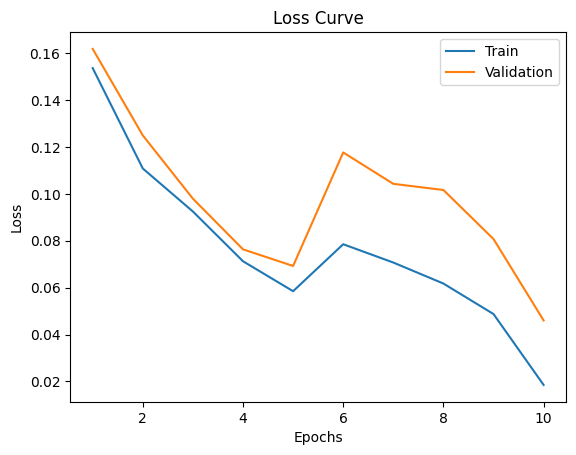

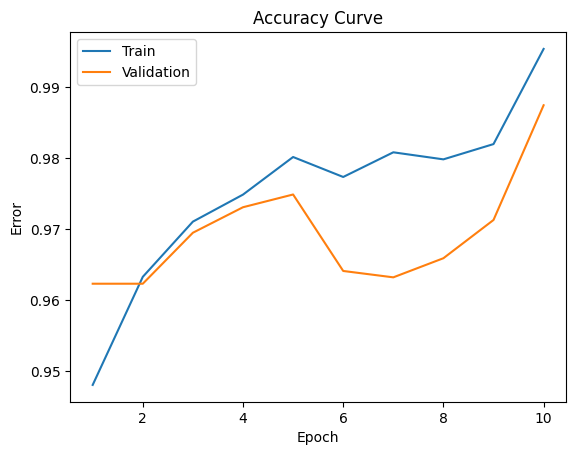

In [ ]:
base_model = RNN(len(text_field.vocab), len(text_field.vocab))
train_RNN(base_model, train_iter, valid_iter, num_epochs=10, learning_rate=1e-3)

#train accuracy: 0.9954 | validation accuracy: 0.9874
#train loss: 0.01849 | validation loss: 0.04602

Epoch: 0 | Training acc: 0.9560959686632936 |Validation acc: 0.9488789237668162 | Training loss: 0.15343750118630228 | Validation loss: 0.2044557448890474
Epoch: 1 | Training acc: 0.9600130569609924 |Validation acc: 0.9533632286995516 | Training loss: 0.12097613527704937 | Validation loss: 0.1696036159992218
Epoch: 2 | Training acc: 0.975518198139383 |Validation acc: 0.979372197309417 | Training loss: 0.0807647322898084 | Validation loss: 0.07179549005296496
Epoch: 3 | Training acc: 0.9743757140525543 |Validation acc: 0.968609865470852 | Training loss: 0.07218325402409108 | Validation loss: 0.10886496822867128
Epoch: 4 | Training acc: 0.9877590990696915 |Validation acc: 0.9748878923766816 | Training loss: 0.04092568083101681 | Validation loss: 0.07510046746271352
Epoch: 5 | Training acc: 0.9915129753549862 |Validation acc: 0.9820627802690582 | Training loss: 0.03746040220676386 | Validation loss: 0.06731162440135247
Epoch: 6 | Training acc: 0.9879223110820956 |Validation acc: 0.9820627

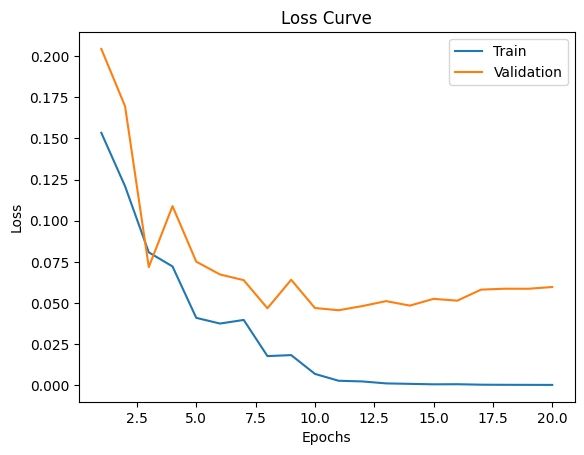

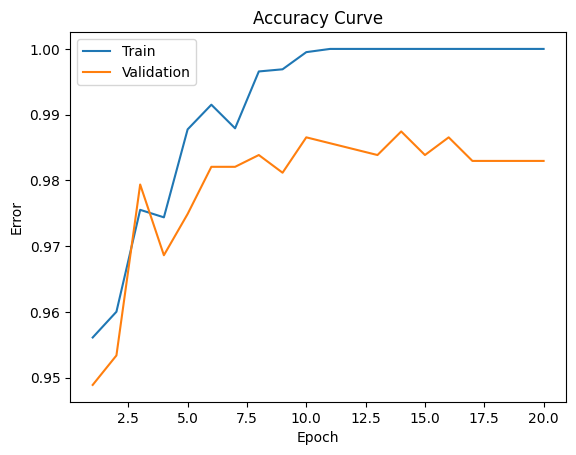

In [ ]:
model4 = RNN(len(text_field.vocab), 2*len(text_field.vocab), num_layers= 1)
train_RNN(model4, train_iter, valid_iter, num_epochs=20, learning_rate=1e-3)

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

spam_iter = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [ ]:
print("False Positive Rate: " + str(1-get_accuracy(model4, nospam_iter)))
print("False Negative Rate: " + str(1 - get_accuracy(model4, spam_iter)))

False Positive Rate: 0.0060975609756097615
False Negative Rate: 0.0992366412213741


In [ ]:
print(get_accuracy(model4, test_iter))
#The final test accuracy is 98.65%.

0.9865350089766607


In [ ]:
# Create a Dataset of only spam test examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

# Create a Dataset of only non-spam test examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

spam_iter1 = torchtext.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

nospam_iter1 = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [ ]:
print("False Positive Rate: " + str(1-get_accuracy(model4, nospam_iter1)))
print("False Negative Rate: " + str(1 - get_accuracy(model4, spam_iter1)))

False Positive Rate: 0.006237006237006182
False Negative Rate: 0.05921052631578949


In [ ]:
msg = "machine learning is sooo cool!"
encoding = torch.tensor([text_field.vocab.stoi[c] for c in msg])
encoding = encoding.reshape(1, len(encoding))
output = model4(encoding)
output = torch.sigmoid(output)
print("My model predicts a " + str(round(output[0][1].item()*100,2)) +
      "% probability of this message being spam")

My model predicts a 1.35% probability of this message being spam
